## Defining Simulator

In [5]:

import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
import torch

freq = np.arange(5.00,1024,1/4)

pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7),
                                                stats.uniform(0,3)],
                                                bounds = bounds)

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)

## Building Network

In [15]:
Nbins = len(freq)
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Sequential(torch.nn.Linear(Nbins, 2048),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(2048),
                                               torch.nn.Linear(2048, 512),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(512),
                                               torch.nn.Linear(512, 256),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(256),
                                               torch.nn.Linear(256, 128),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(128),
                                               torch.nn.Linear(128, 32),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(32),
                                               torch.nn.Linear(32, 8),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(8),
                                              )
        self.summarizer = torch.nn.Linear(Nbins, 16)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features=16, num_params=2, varnames='z')
        
    def forward(self, A, B):
        s = self.summarizer(A['x'])
        logratios = self.logratios(s, B['z'])
#         logratios = self.logratios(A['x'], B['z'])
#         s = self.summarizer(A['x'])
#         s = s.unsqueeze(-1)
        return logratios #self.logratios(s, B['z']), s

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2399.19it/s]


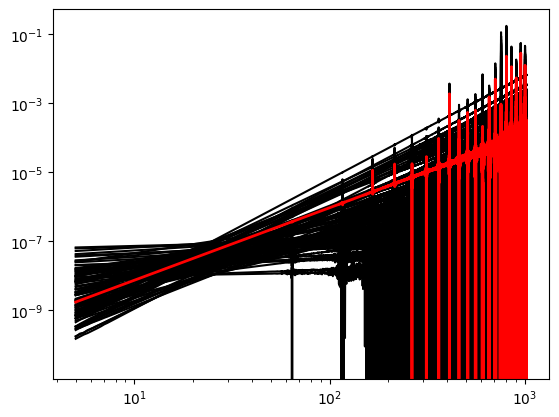

In [10]:
fref = 25
CE_PSD = np.genfromtxt("/Users/abbystokes/Documents/GitHub/DSMMA-Research/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("/Users/abbystokes/Documents/GitHub/DSMMA-Research/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)
for i in range(len(samples)):
    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

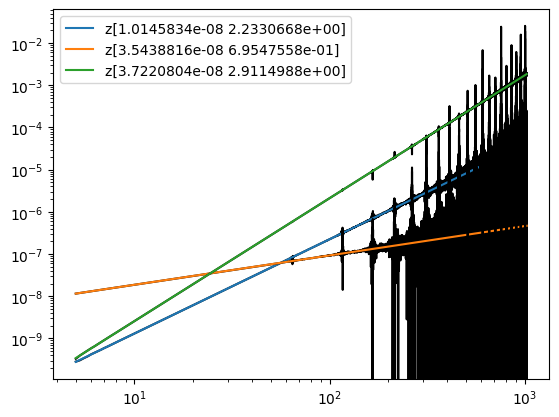

In [11]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

## Fitting Data to Net

In [16]:
def round(obs, bounds=None):
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
    samples = sim.sample(20000)
    dm = swyft.SwyftDataModule(samples, batch_size=64)
    trainer = swyft.SwyftTrainer(accelerator="cpu", precision = 64)
    network = Network()
    trainer.fit(network, dm)
    prior_samples = sim.sample(N = 10000, targets=['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold=1e-2)
    return predictions, new_bounds, samples

In [17]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(5):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

100%|██████████| 20000/20000 [00:06<00:00, 2946.49it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 313/313 [00:07<00:00, 44.51it/s, loss=-0.965, v_num=5, val_loss=1.860]
Reloading best model: /Users/abbystokes/Downloads/lightning_logs/version_5/checkpoints/epoch=6-step=1750.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14745.78it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 25.40it/s]
New bounds: tensor([[1.0002e-08, 9.9934e-08],
        [1.7181e+00, 2.8966e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2939.72it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 45.45it/s, loss=-1.58, v_num=6, val_loss=41.90] 
Reloading best model: /Users/abbystokes/Downloads/lightning_logs/version_6/checkpoints/epoch=0-step=250.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 15568.73it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 28.66it/s]
New bounds: tensor([[1.0002e-08, 9.9850e-08],
        [1.7183e+00, 2.5826e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2944.05it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 20: 100%|██████████| 313/313 [00:07<00:00, 42.11it/s, loss=-1.93, v_num=7, val_loss=3.410]
Reloading best model: /Users/abbystokes/Downloads/lightning_logs/version_7/checkpoints/epoch=15-step=4000.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 15005.53it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 27.10it/s]
New bounds: tensor([[5.0197e-08, 6.6067e-08],
        [2.0651e+00, 2.1842e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2976.41it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 313/313 [00:07<00:00, 43.84it/s, loss=-1.07, v_num=8, val_loss=37.30] 
Reloading best model: /Users/abbystokes/Downloads/lightning_logs/version_8/checkpoints/epoch=1-step=500.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14390.56it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 28.55it/s]
New bounds: tensor([[5.0201e-08, 6.1999e-08],
        [2.0651e+00, 2.1267e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2961.86it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 42.57it/s, loss=-0.545, v_num=9, val_loss=16.60]    
Reloading best model: /Users/abbystokes/Downloads/lightning_logs/version_9/checkpoints/epoch=0-step=250.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14563.76it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 28.32it/s]
New bounds: tensor([[5.0202e-08, 6.1998e-08],
        [2.0651e+00, 2.1267e+00]], dtype=torch.float64)


## Visualize Posterior Parameters

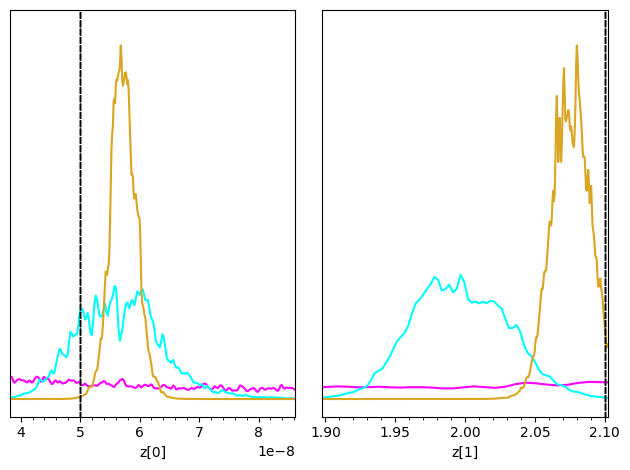

In [14]:
# without batch normalization

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

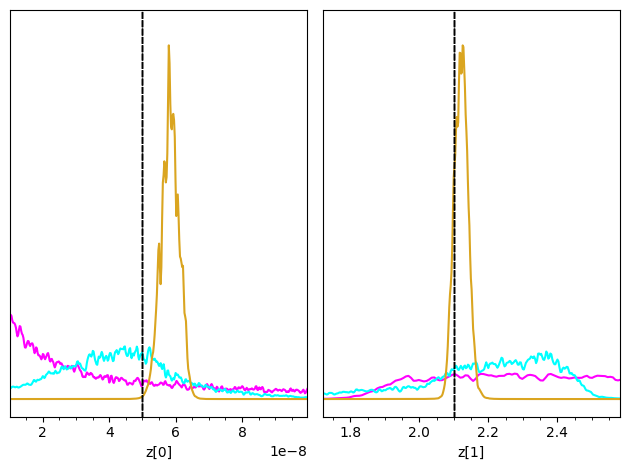

In [21]:
# with batch normalization
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])